Loading data from: amazon_eda_python.csv

Dataset shape: (1465, 16)

Columns:
['product_id', 'product_name', 'category', 'discounted_price', 'actual_price', 'discount_percentage', 'rating', 'rating_count', 'about_product', 'user_id', 'user_name', 'review_id', 'review_title', 'review_content', 'img_link', 'product_link']

--- Head ---
                                                                     0  \
product_id                                                  B07JW9H4J1   
product_name         Wayona Nylon Braided USB to Lightning Fast Cha...   
category             Computers&Accessories|Accessories&Peripherals|...   
discounted_price                                                  ₹399   
actual_price                                                    ₹1,099   
discount_percentage                                                64%   
rating                                                             4.2   
rating_count                                                    24,269  

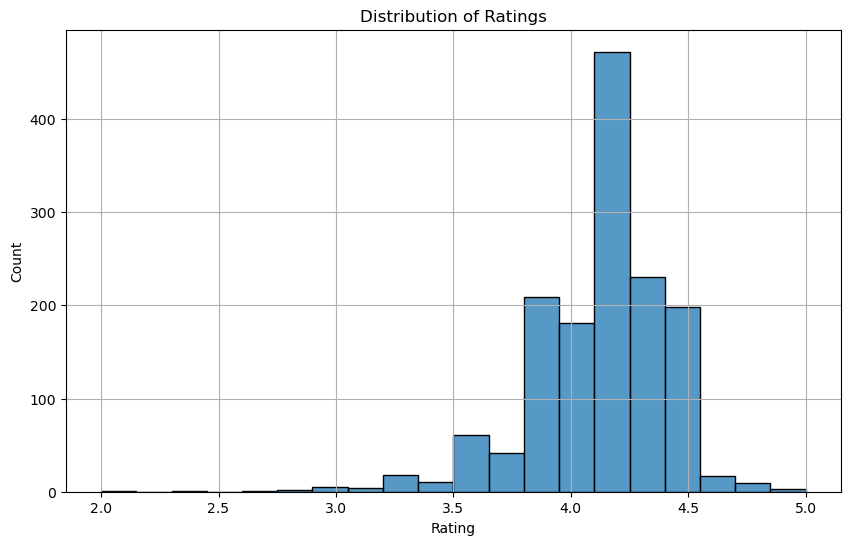

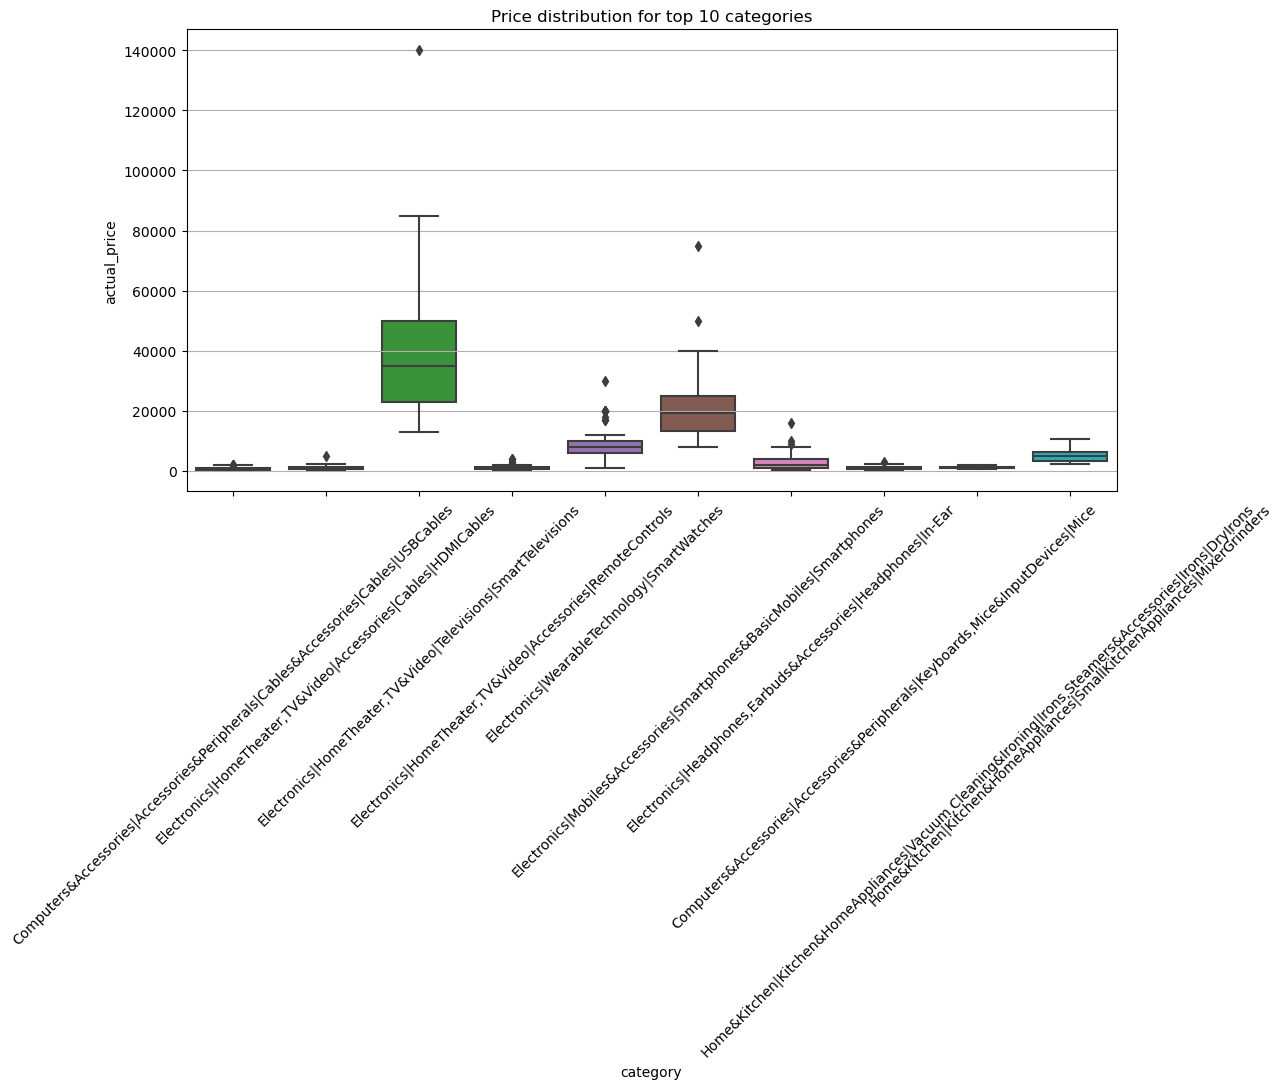

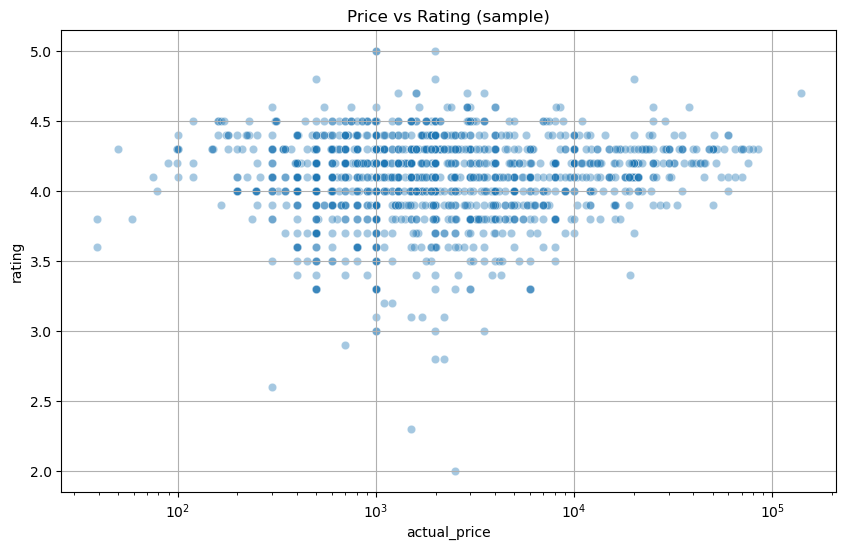

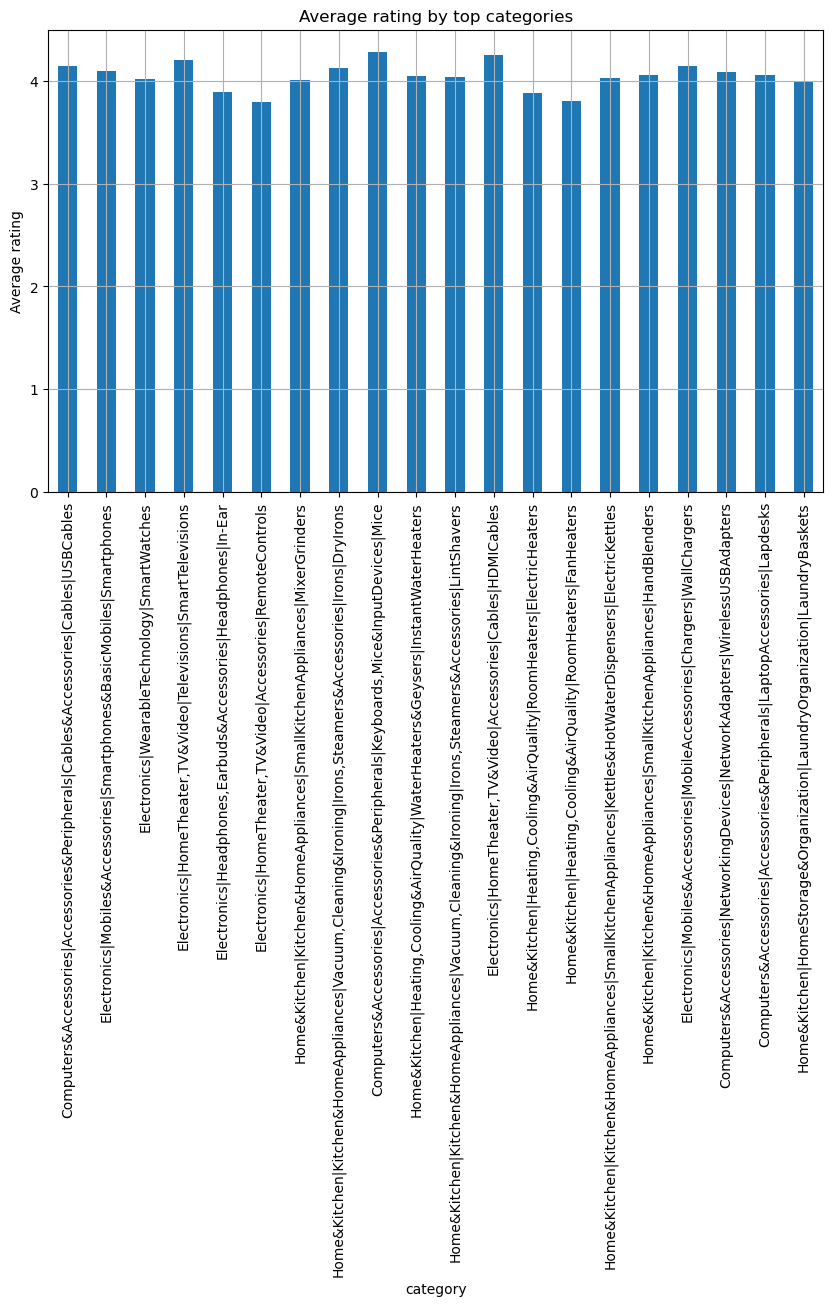


Category performance (top 10):
                                              category  product_count  \
10   Computers&Accessories|Accessories&Peripherals|...            161   
117  Electronics|Mobiles&Accessories|Smartphones&Ba...             68   
119        Electronics|WearableTechnology|SmartWatches             62   
97   Electronics|HomeTheater,TV&Video|Televisions|S...             60   
76   Electronics|Headphones,Earbuds&Accessories|Hea...             51   
93   Electronics|HomeTheater,TV&Video|Accessories|R...             49   
169  Home&Kitchen|Kitchen&HomeAppliances|SmallKitch...             27   
181  Home&Kitchen|Kitchen&HomeAppliances|Vacuum,Cle...             24   
18   Computers&Accessories|Accessories&Peripherals|...             24   
140  Home&Kitchen|Heating,Cooling&AirQuality|WaterH...             23   

     avg_rating  median_price  avg_discount_pct  total_reviews  
10     4.151931         845.0         59.377682        3547816  
117    4.100000       19249.0     

In [2]:
# Amazon E-commerce Analysis (Jupyter-ready Python script)
# Save this file as a .py and open in Jupyter Notebook / JupyterLab (or paste cells into a .ipynb)

"""
MARKDOWN: # Amazon E‑commerce Exploratory Data Analysis

**Problem statement:** Conduct EDA on the Amazon E-commerce Dataset to extract insights on product performance, pricing, discounts, ratings, and reviews. Deliverables:
- Cleaned dataset
- Visualizations
- Grouped summary statistics
- Hypothesis tests (t-test and Chi-Square)
- Notebook documenting observations

**Usage:**
1. Place your dataset CSV file in the same folder and update `DATA_PATH` below.
2. Install required libraries if missing: `pip install pandas numpy matplotlib seaborn scipy scikit-learn jupyter`
3. Run cells in order in a Jupyter environment.

"""

# ---------------------------
# USER CONFIG
# ---------------------------
DATA_PATH = 'amazon_eda_python.csv'  # <-- change this to your CSV filename or full path
REPORT_OUTPUT = 'amazon_eda_report.md'  # optional summary output

# ---------------------------
# Imports
# ---------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import KBinsDiscretizer
import warnings
warnings.filterwarnings('ignore')

# For prettier plots in notebook
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['axes.grid'] = True

# ---------------------------
# 1. Load data & initial checks
# ---------------------------
print('Loading data from:', DATA_PATH)
try:
    df = pd.read_csv(DATA_PATH)
except Exception as e:
    raise SystemExit(f"Failed to read {DATA_PATH}: {e}")

print('\nDataset shape:', df.shape)
print('\nColumns:')
print(df.columns.tolist())

# Quick peek
print('\n--- Head ---')
print(df.head().T)

print('\n--- Info ---')
print(df.info())

print('\n--- Missing value counts ---')
print(df.isnull().sum())

# ---------------------------
# 2. Data cleaning & preprocessing
# ---------------------------
# Standardize column names: strip, lower, replace spaces with underscore
orig_columns = df.columns.tolist()
col_map = {c: c.strip().lower().replace(' ', '_') for c in orig_columns}
df.rename(columns=col_map, inplace=True)

# Typical numeric columns that may be strings with currency symbols; attempt to coerce
for col in ['discounted_price', 'actual_price', 'discount_percentage', 'rating', 'rating_count']:
    if col in df.columns:
        # remove common non-numeric chars
        df[col] = df[col].astype(str).str.replace('[^0-9.\-]', '', regex=True)
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Remove exact duplicate rows
dups = df.duplicated().sum()
print(f'Exact duplicates: {dups}')
if dups>0:
    df = df.drop_duplicates().reset_index(drop=True)

# Drop irrelevant columns if exist and mostly empty: img_link, product_link, review_title (optional keep)
optional_drop = ['img_link','product_link']
for c in optional_drop:
    if c in df.columns:
        # drop column only if it's mostly empty or user doesn't need images/links
        percent_nonnull = df[c].notnull().mean()
        if percent_nonnull < 0.2:
            print(f'Dropping mostly-empty column: {c}')
            df.drop(columns=[c], inplace=True)

# Handle missing values: summary and strategy notes
missing_summary = df.isnull().mean().sort_values(ascending=False)
print('\nMissing (fraction) by column:\n', missing_summary)

# Strategy: For product-level info (product_id, product_name, category, actual_price) we keep rows with product_id or product_name.
if 'product_id' in df.columns:
    df = df[~df['product_id'].isnull()]

# For numeric missing: impute or leave depending on use-case
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print('\nNumeric columns detected:', num_cols)

# Example: fill rating_count NaN with 0, rating NaN left as NaN (some products unrated)
if 'rating_count' in df.columns:
    df['rating_count'] = df['rating_count'].fillna(0).astype(int)

# For missing prices, we cannot impute reliably; flag them and drop if needed later

# Trim whitespace in text columns
text_cols = df.select_dtypes(include=['object']).columns.tolist()
for c in text_cols:
    df[c] = df[c].astype(str).str.strip()

# ---------------------------
# 3. Feature engineering
# ---------------------------
# Create discount_amount if missing
if 'actual_price' in df.columns and 'discounted_price' in df.columns:
    df['discount_amount'] = df['actual_price'] - df['discounted_price']
    # if discount_percentage missing, compute
    if 'discount_percentage' in df.columns:
        df['discount_percentage'] = df['discount_percentage'].fillna((df['discount_amount'] / df['actual_price']) * 100)
    else:
        df['discount_percentage'] = (df['discount_amount'] / df['actual_price']) * 100

# rating_level categorical
if 'rating' in df.columns:
    bins = [0, 3.0, 4.0, 5.01]
    labels = ['Low', 'Medium', 'High']
    df['rating_level'] = pd.cut(df['rating'].fillna(0), bins=bins, labels=labels, include_lowest=True)

# price_bins (for contingency tests or segmentation) -- use quantiles or KBinsDiscretizer
if 'actual_price' in df.columns:
    df['price_bin_quantile'] = pd.qcut(df['actual_price'].rank(method='first'), q=4, labels=['Q1','Q2','Q3','Q4'])

# ---------------------------
# 4. Descriptive statistics & EDA
# ---------------------------
# Overall summary
summary_numeric = df[num_cols].describe().T
print('\nNumeric summary:')
print(summary_numeric)

# Top categories by product count
if 'category' in df.columns:
    cat_counts = df['category'].value_counts().head(20)
    print('\nTop categories by count:')
    print(cat_counts)

# Top products by rating_count and avg rating
if 'product_id' in df.columns and 'rating' in df.columns:
    prod_stats = df.groupby(['product_id','product_name','category']).agg(
        avg_rating=('rating','mean'),
        rating_count_total=('rating_count','sum'),
        price_mean=('actual_price','mean'),
        discount_pct_mean=('discount_percentage','mean')
    ).reset_index()
    top_by_ratings = prod_stats.sort_values(['avg_rating','rating_count_total'], ascending=[False,False]).head(20)
    print('\nTop products by average rating and votes:')
    print(top_by_ratings[['product_id','product_name','category','avg_rating','rating_count_total']].head(10))

# ---------------------------
# 5. Outlier detection (IQR method) for prices & ratings
# ---------------------------
def iqr_outliers(s):
    if s.dropna().empty:
        return pd.Series(False, index=s.index)
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr
    return (s < lower) | (s > upper)

for col in ['actual_price','discounted_price','rating_count']:
    if col in df.columns:
        out_mask = iqr_outliers(df[col])
        print(f'{col}: potential outliers = {out_mask.sum()} of {len(df)}')

# ---------------------------
# 6. Visualizations (examples)
# ---------------------------
# NOTE: Run these cells in Jupyter to view plots.

# 6.1 Distribution of ratings
if 'rating' in df.columns:
    plt.figure()
    sns.histplot(df['rating'].dropna(), bins=20)
    plt.title('Distribution of Ratings')
    plt.xlabel('Rating')
    plt.show()

# 6.2 Boxplot of actual_price by category (top categories only)
if 'category' in df.columns and 'actual_price' in df.columns:
    top_cats = df['category'].value_counts().nlargest(10).index
    plt.figure(figsize=(12,6))
    sns.boxplot(x='category', y='actual_price', data=df[df['category'].isin(top_cats)])
    plt.xticks(rotation=45)
    plt.title('Price distribution for top 10 categories')
    plt.show()

# 6.3 Scatter plot: price vs rating
if 'actual_price' in df.columns and 'rating' in df.columns:
    plt.figure()
    sns.scatterplot(x='actual_price', y='rating', alpha=0.4, data=df.sample(n=min(2000,len(df)), random_state=1))
    plt.xscale('log')
    plt.title('Price vs Rating (sample)')
    plt.show()

# 6.4 Category-level aggregated bar charts
if 'category' in df.columns and 'rating' in df.columns:
    cat_agg = df.groupby('category').agg(avg_rating=('rating','mean'), avg_price=('actual_price','mean'), count_products=('product_id','nunique'))
    cat_agg = cat_agg.sort_values('count_products', ascending=False).head(20)
    plt.figure()
    cat_agg['avg_rating'].plot(kind='bar')
    plt.title('Average rating by top categories')
    plt.ylabel('Average rating')
    plt.show()

# ---------------------------
# 7. Groupby & Aggregations (examples)
# ---------------------------
# Performance metrics by category
if 'category' in df.columns:
    category_perf = df.groupby('category').agg(
        product_count=('product_id','nunique'),
        avg_rating=('rating','mean'),
        median_price=('actual_price','median'),
        avg_discount_pct=('discount_percentage','mean'),
        total_reviews=('rating_count','sum')
    ).reset_index().sort_values('product_count', ascending=False)
    print('\nCategory performance (top 10):')
    print(category_perf.head(10))

# Top 10 products by total rating_count
if 'product_id' in df.columns:
    prod_by_reviews = df.groupby(['product_id','product_name']).agg(total_votes=('rating_count','sum'), avg_rating=('rating','mean')).reset_index().sort_values('total_votes', ascending=False)
    print('\nTop products by review votes:')
    print(prod_by_reviews.head(10))

# ---------------------------
# 8. Hypothesis Testing
# ---------------------------
# 8.1 T-test: compare mean ratings of Electronics vs Clothing
if 'category' in df.columns and 'rating' in df.columns:
    cat_a = 'Electronics'
    cat_b = 'Clothing'
    a = df.loc[df['category']==cat_a, 'rating'].dropna()
    b = df.loc[df['category']==cat_b, 'rating'].dropna()
    print(f'Counts -> {cat_a}: {len(a)}, {cat_b}: {len(b)}')
    # Only perform t-test if both samples are reasonably sized
    if len(a) >= 20 and len(b) >= 20:
        tstat, pval = stats.ttest_ind(a, b, equal_var=False, nan_policy='omit')
        print(f'T-test between {cat_a} and {cat_b}: t={tstat:.4f}, p={pval:.4e}')
        if pval < 0.05:
            print('Result: Statistically significant difference in mean ratings (alpha=0.05)')
        else:
            print('Result: No statistically significant difference in mean ratings (alpha=0.05)')
    else:
        print('Not enough data for t-test for the chosen categories. Consider using other categories or combining data.')

# 8.2 Chi-Square: is price category associated with rating level?
if 'price_bin_quantile' in df.columns and 'rating_level' in df.columns:
    contingency = pd.crosstab(df['price_bin_quantile'], df['rating_level'])
    print('\nContingency table (price_bin_quantile x rating_level):')
    print(contingency)
    chi2, p, dof, expected = stats.chi2_contingency(contingency)
    print(f'Chi-square test: chi2={chi2:.4f}, p={p:.4e}, dof={dof}')
    if p < 0.05:
        print('Result: Reject null — rating level is associated with price bin (alpha=0.05)')
    else:
        print('Result: Fail to reject null — no evidence of association at alpha=0.05')

# ---------------------------
# 9. Save cleaned dataset & summary
# ---------------------------
CLEANED_PATH = 'amazon_ecom_cleaned.csv'
try:
    df.to_csv(CLEANED_PATH, index=False)
    print(f'Cleaned dataset saved to {CLEANED_PATH}')
except Exception as e:
    print('Failed to save cleaned dataset:', e)

# Optional: write short markdown report with a few findings
report_lines = []
report_lines.append('# Amazon E-commerce EDA — Summary')
report_lines.append(f'Dataset loaded from: {DATA_PATH}')
report_lines.append(f'Cleaned dataset saved to: {CLEANED_PATH}')
report_lines.append('\n## Key numeric summaries')
report_lines.append(summary_numeric.to_markdown())

with open(REPORT_OUTPUT, 'w', encoding='utf-8') as f:
    f.write('\n\n'.join(report_lines))
print('Basic markdown report saved to', REPORT_OUTPUT)

# ---------------------------
# 10. Next steps & recommendations (add to notebook as markdown):
# - Perform text analysis (NLP) on review_content to extract sentiment and common complaints/praise.
# - Time-series: if you have order date, analyze seasonality and promotional impacts.
# - Product-level A/B tests: test different discount levels to measure elasticity.
# - Build dashboards (Power BI / Tableau) for category managers with filters for category, price band, rating level.
# - Consider building a product recommendation model using collaborative filtering.
# ---------------------------

print('\nNotebook run complete. Review plots and the generated cleaned CSV and markdown report.')
